<a id='section_id3'></a>
# Auslegung Speicherkapazität - Lastprofil 31 und 10kWp PV

Bei Batteriespeichern ist der Aufwand für die Erhöhung der Speicherkapazität groß, weshalb diese nur so groß wie nötig sein sollte. In diesem Spript wird der Einfluss der Speicherkapazität auf die Effektivität der Speicherlösung untersucht. Außerdem wird geprüft, wie viel Wassestoff eingespeichert werden muss um verschieden große reversible Brennstoffzellensysteme zu betreiben.

## Formelzeichen

\begin{eqnarray}
E_{bat\_jahr} &=& Durch\ Batterie\ über\ ein\ Jahr\ umgesetzte\ Energie\\
E_{bat\_max} &=& Batterie\ Kapazität\\
E_{RFC\_jahr} &=& Durch\ Wasserstoffrückverstromung\ über\ ein\ Jahr\ umgesetzte\ Energie\\
\\
P_{bat\_charge}&=& Einspeicherleistung\ Batterie\\
P_{bat\_discharge} &=& Ausspeicherleistung\ Batterie\\
P_{RFC\_charge}&=& Elektrolyseurleistung\ Wasserstoffrückverstromung\\
P_{RFC\_discharge} &=& Brennstoffzellenleistung\ Wasserstoffrückverstromung\\
\end{eqnarray}

\
Verwendete Skripte:\
[Parameter Base Case](parameter_base_case.py)\
[Hilfsfunktionen](own_utility_functions.py)\
[Visualisierung](visualisation.py)\
[Speicher](speicher.py)

## Initialisierung

In [1]:
from parameter_base_case import *

Nummer = '31' 

directory = directory_data+'Lastprofil_' + Nummer +'.npy'
with open(directory, 'rb') as f:
    [P_verbraucher, P_pv, P_dif, P_def, P_ueber] = np.load(f)

E_verbraucher = jahresenergie_kWh(P_verbraucher)
E_def = jahresenergie_kWh(P_def)
E_ueber = jahresenergie_kWh(P_ueber)

#Zeitausschnitte für Visualisierung
days = timeline.minute_period('2019-07-22','2019-07-25')
year = timeline.minute_period('2019-01-01','2019-12-31')
year_dayres = timeline.day_period('2019-01-01','2019-12-31')

# -------------------------------------------------------------------------------------------------------------

## Batteriespeicher Einfluss Kapazität auf Eigenstromnutzung

In [6]:
E_bat_max_array = np.concatenate((np.linspace(0,20,15), np.linspace(20,200,5)), axis=0)  #niedrige Auflösung zum testen
#E_bat_max_array = np.concatenate((np.linspace(0,12,40), np.linspace(20,200,30)), axis=0)  #hohe Auflösung mit mehreren Minuten Rechenzeit


E_bat_jahr=np.zeros(np.size(E_bat_max_array))
print('<Simulationsfortschritt>')
for i,value in enumerate(E_bat_max_array):
    E_bat,P_bat_charge,P_bat_discharge = speicher.batterie_lastprofile(P_dif, P_bat_charge_max, \
            P_bat_discharge_max, eff_bat, value)
    E_bat_jahr[i] = jahresenergie_kWh(P_bat_discharge)
    size="%3.1f" % value +'kWh'
    
    ##Ladezustand und Ladeleistung ausschnitt
    #vis.plot_timeline(days,P_bat_charge-P_bat_discharge,'Speicherleistung in W','Lastprofil Batterie '+size)
    #vis.plot_timeline(days,E_bat,'Speicherfüllstand in kWh','Speicherfüllstand Batterie '+size)
    #plt.show()
    
    print('.',end="")



<Simulationsfortschritt>
....................

(-1, 20)

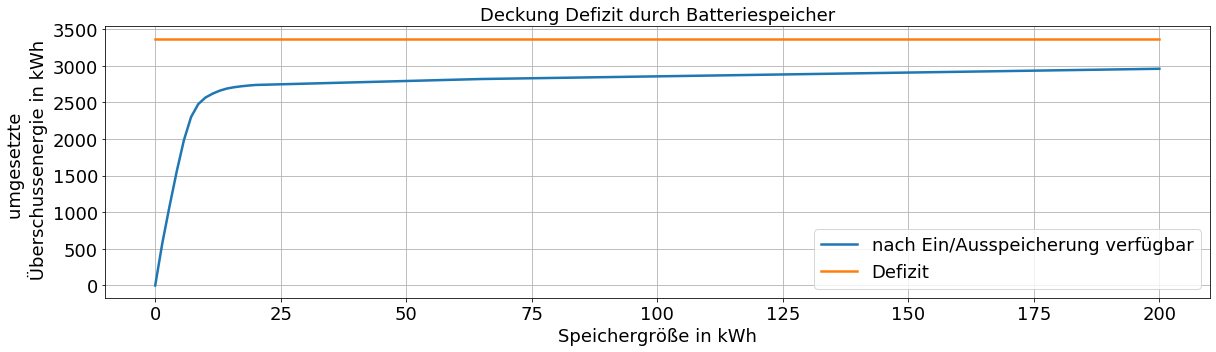

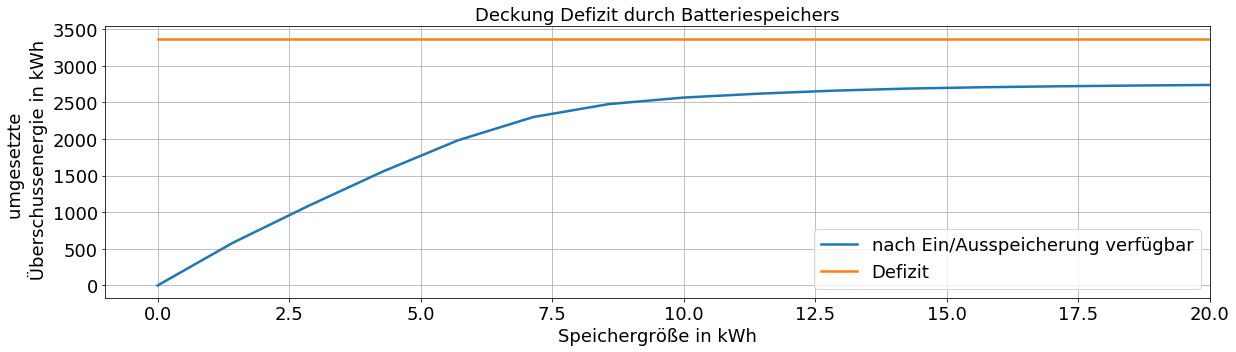

In [10]:
ax=vis.plot(E_bat_max_array,E_bat_jahr,'Speichergröße in kWh'\
            ,'umgesetzte \n Überschussenergie in kWh','Deckung Defizit durch Batteriespeicher')
vis.addtoplot(ax,E_bat_max_array,np.zeros(np.size(E_bat_max_array))+jahresenergie_kWh(P_def),\
              ['nach Ein/Ausspeicherung verfügbar','Defizit'],'lower right')

#plt.xlim(-1,200)
vis.save_to_tex('diagramm_defizitabdeckung_batterie',ax)


ax=vis.plot(E_bat_max_array,E_bat_jahr,'Speichergröße in kWh'\
            ,'umgesetzte \n Überschussenergie in kWh','Deckung Defizit durch Batteriespeichers')
vis.addtoplot(ax,E_bat_max_array,np.zeros(np.size(E_bat_max_array))+jahresenergie_kWh(P_def),\
              ['nach Ein/Ausspeicherung verfügbar','Defizit'],'lower right')
plt.xlim(-1,20)


# --------------------------------------------------------------------------------------------------------------

## Bedarf Speicherkapazität bei verschiedener Einspeicherleistung für Wasserstoffrückverstromung

<Simulationsfortschritt>
....................



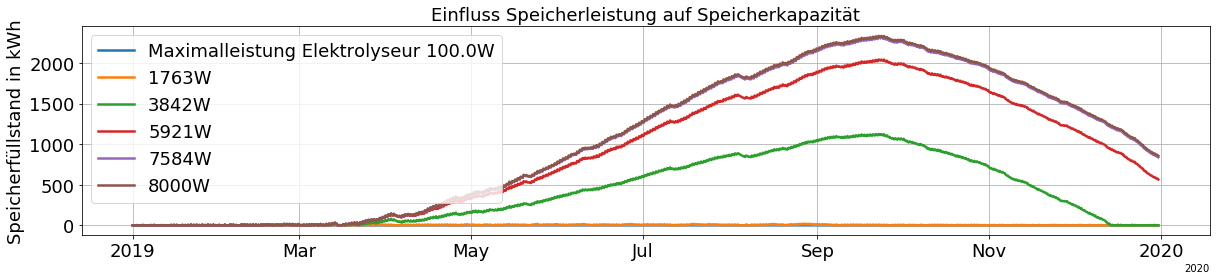

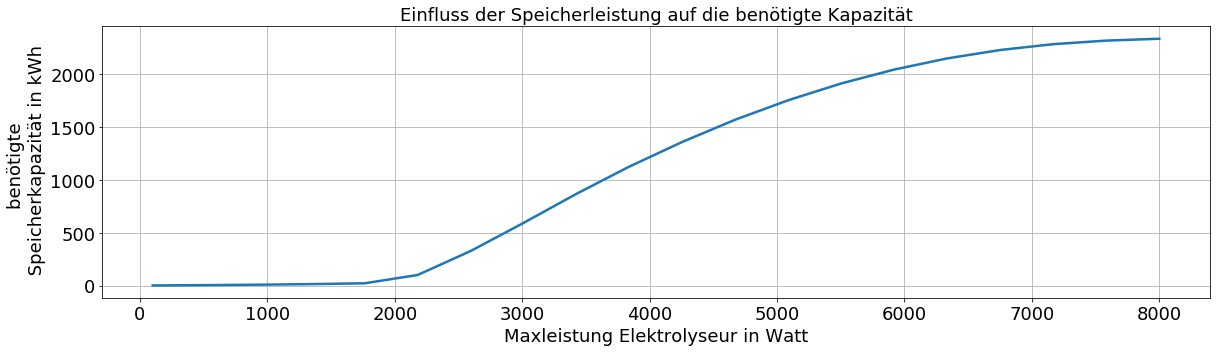

In [4]:
P_RFC_charge_max_array = np.linspace(100,8000,20)
#P_RFC_charge_max_array = np.linspace(0,3000,20)
P_RFC_discharge_max=2000

print('<Simulationsfortschritt>')
first=0
for value in P_RFC_charge_max_array:
    E_h2_array, P_elektrolyse_array, P_fuelcell_array = speicher.RFC_lastprofile(P_dif, value, P_RFC_discharge_max, eff_elektrolyse, eff_brennstoffzelle, E_h2_max, E_h2_start)
    if first==0:        
        ax=vis.plot_timeline(year,E_h2_array,'Speicherfüllstand in kWh','Einfluss Speicherleistung auf Speicherkapazität')
        legend = ['Maximalleistung Elektrolyseur '+ "%4.1f" % value +'W']
        E_h2_max_array = [np.max(E_h2_array)]
        E_RFC_jahr = [jahresenergie_kWh(P_fuelcell_array)]
        first=1
    else:
        if value%len(P_RFC_charge_max_array)/5 < 1:  #nur eimzelne Datenreihen werden im Diagramm angezeigt. Teiler gibt Menge an
            legend.append("%4.0f" % value +'W')
            vis.addtoplot_timeline(ax,year,E_h2_array,legend)
        E_h2_max_array.append(np.max(E_h2_array))
        E_RFC_jahr.append(jahresenergie_kWh(P_fuelcell_array))
    print('.',end="")       
vis.save_to_tex('diagramm_speicherleistung_einfluss_kapazitaet'+'_'+file_extension, ax)

ax=vis.plot(P_RFC_charge_max_array,E_h2_max_array,'Maxleistung Elektrolyseur in Watt','benötigte \n Speicherkapazität in kWh','Einfluss der Speicherleistung auf die benötigte Kapazität')
vis.save_to_tex('diagramm_speicherleistungvskapazitaetsbedarf'+'_'+file_extension, ax)

Wasserstoffrückverstromung als Saisonalspeicher erst ab ca 2500W sinnvoll, da vorher kaum Einspeicherung über Tag/Nacht heraus

### Autarkiegrad

oft wird der Autarkiegrad als Kenngröße für den Nutzen eines Speichers benutzt. Welchen Einfluss hat die Kapazität auf die Autarkie?

In [11]:
autarkiegrad_RFC = (E_verbraucher-jahresenergie_kWh(P_def)+E_RFC_jahr)/E_verbraucher*100
ax=vis.plot(E_h2_max_array,autarkiegrad_RFC,'benötigte Speicherkapazität in kWh','Autarkiegrad in %','Speicherkapazität - Autarkiegrad')

autarkiegrad_bat = (E_verbraucher-jahresenergie_kWh(P_def)+E_bat_jahr)/E_verbraucher*100
vis.addtoplot(ax,E_bat_max_array,autarkiegrad_bat)

ax.legend(['RFC','Batterie'],fontsize=14)

#plt.ylim(0,100)
plt.xlim(0,600)
#vis.save_to_tex('diagramm_SpeicherkapazitaetBedarf_Autarkiegrad', ax)


(0, 600)

Für vollständige Autarkie ist ein sehr großer Aufwand notwendig während wenige kWh bereits einen sehr großen Effekt haben (Tag-Nacht-Speicherung). Durch die hohen Verluste ist Wasserstoffrückverstromung dutlich weniger effektiv dafür ist hier eine hohe Kapazität günstiger zu bekommen.